In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from GraphST import GraphST

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'

In [39]:
# the number of clusters
n_clusters = 9

In [5]:
dataset = 'GSE198353_mmtv_pymt'

In [8]:
# input_dir = 'C:/Users/AGNISH/Desktop/IITK/VSCode/GraphST/151673/'
# adata = sc.read_10x_h5(input_dir +'filtered_feature_bc_matrix.h5')
# adata.var_names_make_unique()

# read data
file_fold = 'C:/Users/AGNISH/GraphST/Data/SPOTS_Landau/' + str(dataset) #please replace 'file_fold' with the download path
temp = sc.read_visium(file_fold, count_file='GSE198353_mmtv_pymt_GEX_filtered_feature_bc_matrix.h5', load_images=True)
temp.var_names_make_unique()

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
temp.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43
AAACATGGTGAGAGGA-1,1,62,0
...,...,...,...
TTGTTGGCAATGACTG-1,1,76,30
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27


In [10]:
temp.var

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm1992,ENSMUSG00000089699,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm19938,ENSMUSG00000102331,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm37381,ENSMUSG00000102343,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Rp1,ENSMUSG00000025900,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
...,...,...,...
AC133095.2,ENSMUSG00000095475,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC133095.1,ENSMUSG00000094855,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC234645.1,ENSMUSG00000095019,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC149090.1,ENSMUSG00000095041,Gene Expression,MMTV_PyMT_gex-mm10-2020-A


In [13]:
input_dir = 'C:/Users/AGNISH/GraphST/Data/SPOTS_Landau/' + str(dataset)
adata = sc.read_csv(input_dir+ '/GSE198353_mmtv_pymt_ADT_transpose.csv', delimiter=",", dtype='float32')
adata.var_names_make_unique()

In [14]:
adata.obs

""
AAACAAGTATCTCCCA-1
AAACACCAATAACTGC-1
AAACAGGGTCTATATT-1
AAACAGTGTTCCTGGG-1
AAACATGGTGAGAGGA-1
...
TTGTTGGCAATGACTG-1
TTGTTTCACATCCAGG-1
TTGTTTCATTAGTCTA-1
TTGTTTCCATACAACT-1


In [17]:
adata.obsm=temp.obsm

In [15]:
adata.var

""
CD4
CD8a
CD366
CD279
CD117
Ly-6C
Ly-6G
CD19
CD45
CD25


In [16]:
adata.uns=temp.uns

In [20]:
adata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
file_fold

'C:/Users/AGNISH/GraphST/Data/151673'

In [21]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [01:04<00:00,  9.24it/s]

Optimization finished for ST data!


In [22]:
adata

AnnData object with n_obs × n_vars = 1978 × 32
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [40]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [24]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [25]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6331903767517718


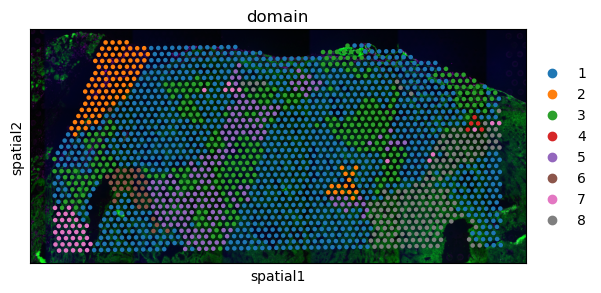

In [41]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth", "domain"],
              color=["domain"],
              #title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

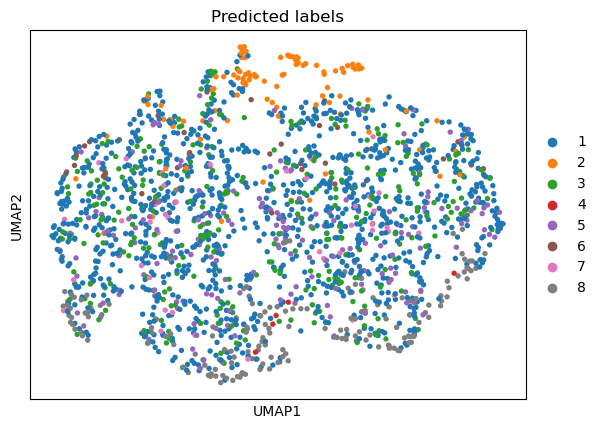

In [42]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

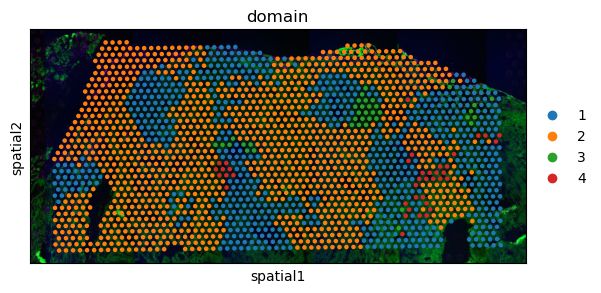

In [37]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth", "domain"],
              color=["domain"],
              #title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

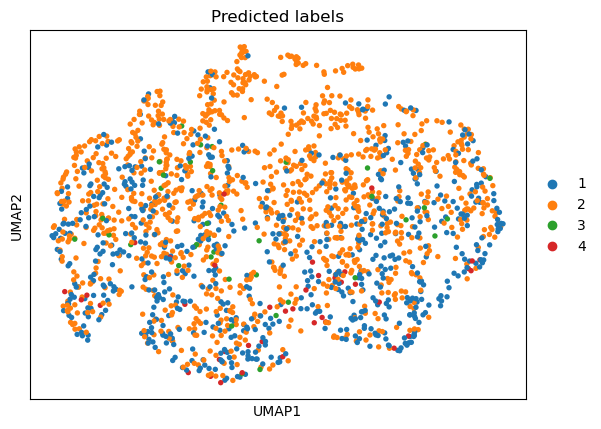

In [38]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)